# Representation Learning at the Houses of the Oireachtas in Ireland

Notebook dedicated to run representation learning on the Houses of the Oireachtas' data in Ireland.

This work is based on a Senator Representations' work of the US Congress by Nathaniel Tucker:

https://github.com/knathanieltucker/tf-keras-tutorial/blob/master/SenatorRepresentations.ipynb

The Oireachtas is the legislature of the Republic of Ireland.

The Oireachtas consists of:
- The President of Ireland
- The two houses of the Oireachtas:
    - Dáil Éireann (lower house)
    - Seanad Éireann (upper house)
    
Further info: https://en.wikipedia.org/wiki/Oireachtas

Information regarding the Houses of the Oireachtas is featured on their website, including legislation, and is the copyright of the Houses of the Oireachtas: https://beta.oireachtas.ie/. 

Another interesting resource is https://www.kildarestreet.com/ which is a searchable archive of everything that's been said in the Dáil and all written parliamentary questions since January 2004, everything in the Seanad since September 2002, and all Committee meetings since September 2012.

Open Data from the Houses of the Oireachtas can be accessed via:
https://beta.oireachtas.ie/en/open-data/

This includes a link to the open data APIs via a Swagger UI:
https://api.oireachtas.ie/

A vote in the Houses of the Oireachtas is also called a division. We will be looking at this divisions (votings) table for the house and the Seanad (Senate):

In [1]:
import requests # http://docs.python-requests.org/
from BeautifulSoup import BeautifulSoup
import json
import time
import csv
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = "data/congress/Ireland"

In [3]:
def get_votings(chamber = 'seanad'):  # chamber: 'seanad' or 'dail' if chamber_type: 'house'
    
    votings_data = []

    table = "divisions" # votings table
    url = 'https://api.oireachtas.ie/v1/{}'.format(table)
    date_start = '1900-01-01'
    date_end = '2017-12-31'
    chamber_type = 'house' # 'committee' or 'house'

    batch = 500
    skip = 0
    limit = skip + batch
    count = 1 # start

    while count > 0:

        params = dict(chamber_type=chamber_type,
                      chamber=chamber, 
                      date_start=date_start, 
                      date_end=date_end,
                      skip=skip, 
                      limit=limit)
        r = requests.get(url, params=params)

        print r.url
        # print "Status Code:", r.status_code
        # print "Headers:", r.headers

        # Add data from this batch
        contents = r.json()

        if 'message' in contents and contents['message'] == 'server error':
            print 'ERROR RETRIEVING DATA'
            return votings_data

        # Results    
        votings = contents['results'][:batch] # in order not to have duplicates
        votings_data.extend(votings)

        # Update count, more to retrieve?
        count = len(votings)
        print 'Number retrieved', count
        # Update skip and limit for query
        skip += batch
        limit += batch

        time.sleep(1)
        
    return votings_data

### Seanad Éireann (upper house)

In [4]:
# seanad_data = get_votings()

In [5]:
# with open('%s/seanad_data.json' % (data_path), 'w') as outfile:
#      json.dump(seanad_data, outfile)

In [6]:
seanad_data = json.load(open('%s/seanad_data.json' % (data_path)))

How many votings in the Senate?

In [7]:
len(seanad_data)

3530

In [8]:
# seanad_data[0]

### Dáil Éireann (lower house)

In [9]:
# dail_data = get_votings(chamber = 'dail')

In [10]:
# with open('%s/dail_data.json' % (data_path), 'w') as outfile:
#      json.dump(dail_data, outfile)

In [11]:
dail_data = json.load(open('%s/dail_data.json' % (data_path)))

In [12]:
len(dail_data)

5000

**Note**

The division count for the Dail is actually 7,329 but the API does only let me retrieve the first 5,000 votings

In [13]:
# dail_data[0]

Verify there is no duplicates:

In [14]:
def verify_no_voting_duplicates(vote_data):
    votes = []
    duplicates = []
    for vote in vote_data:
        uri = vote["division"]["uri"]
        if uri not in votes:
            # print uri
            votes.append(uri)
        else:
            duplicates.append(uri)
    return len(duplicates)

In [15]:
verify_no_voting_duplicates(seanad_data)

0

In [16]:
verify_no_voting_duplicates(dail_data)

0

Get members from the votings:

In [17]:
def get_members(vote_data):
    members = set()
    for vote in vote_data:
        div = vote["division"]
        for outcome, voting in div["tallies"].iteritems():            
            if voting is not None:
                # print voting["showAs"] # Tá (YES), Níl (NO), Staon (Abstention)
                # print len(voting["members"])
                for member in voting["members"]:
                    member = member["member"]
                    #last_name, first_name = member["showAs"].split(",")
                    #first_name = first_name[:-1].strip()
                    #last_name = last_name.strip()
                    member_code = member["memberCode"]
                    # print member_code
                    if member_code is not None:
                        members.add(member_code)
    return members

**Senators**

In [18]:
senators = get_members(seanad_data)

In [19]:
list(senators)[3]

u'Maria-Byrne.S.2016-04-25'

In [20]:
len(senators)

197

**Deputies**

In [21]:
deputies = get_members(dail_data)

In [22]:
list(deputies)[2]

u'Martin-Kenny.D.2016-10-03'

In [23]:
len(deputies)

372

All members:

In [24]:
all_members = senators.union(deputies)

In [25]:
len(all_members)

478

In [26]:
# for v, k in enumerate(set(senators)):
#     print v, k

In [27]:
# leave the first two blank for padding and not a member
senator_to_id = { k: v + 2 for v, k in enumerate(senators) }
deputy_to_id = { k: v + 2 for v, k in enumerate(deputies) }

In [28]:
# senator_to_id

In [29]:
len(senator_to_id), len(deputy_to_id)

(197, 372)

In [30]:
def get_member_id(name, collection):
    name = name.replace(" ", "-").replace(".", "")
    sens = [k for k, v in collection.iteritems() if k is not None and k.startswith(name)]
    if len(sens) > 0:
        return sens[0], collection[sens[0]]
    return None, 1

In [31]:
get_member_id('Aideen Hayden', senator_to_id), get_member_id('Aideen Hayden', deputy_to_id)

((u'Aideen-Hayden.S.2011-05-25', 133), (None, 1))

**Parties**

In [32]:
def get_member_party(name):
    uri = 'https://beta.oireachtas.ie/en/members/member/%s/' % (name)
    try:
        page = requests.get(uri).text
        # dom = web.Element(page)
        # party = dom.content.split('<p class="bio-text">Party:</p> <p>')[1].split('</p')[0].strip()
        bs = BeautifulSoup(page)
        er = bs.find(text="Party:")
        party = bs.find(text="Party:").findNext('p').contents[0].strip()
    except:
        party = raw_input('For member %s, please input his/her party manually: ' % (name))
    return party

In [33]:
member = list(senators)[0]

In [34]:
member, get_member_party(member)

(u'Cecilia-Keaveney.D.1996-04-02', u'Fianna F\xe1il')

In [35]:
member = list(deputies)[17]
member, get_member_party(member)

(u'Dessie-Ellis.D.2011-03-09', u'Sinn F\xe9in')

In [36]:
# member = list(all_members)[21] # Willie-O'Dea.D.1982-03-09
# print member
# get_member_party(member) # prompt: For member Willie-O'Dea.D.1982-03-09, please input his/her party manually

In [37]:
def get_parties(members):

    parties = []
    
    for member in members:
        
        print 'Member', member
    
        parties.append(
            {'member': member.strip(),
             'party': get_member_party(member)})
    
    return parties

In [38]:
# parties = get_parties(all_members)

In [39]:
# with open('%s/parties.json' % (data_path), 'w') as outfile:
#      json.dump(parties, outfile)

In [40]:
parties = json.load(open('%s/parties.json' % (data_path)))

In [41]:
parties[0]

{u'member': u'Cecilia-Keaveney.D.1996-04-02', u'party': u'Fianna F\xe1il'}

In [42]:
parties = { party['member']: party['party'] for party in parties }

In [43]:
set(val for val in parties.values())

{u'Anti-Austerity Alliance - People Before Profit',
 u'Ceann Comhairle',
 u'Fianna F\xe1il',
 u'Fine Gael',
 u'Green Party',
 u'Independent',
 u'Independents 4 Change',
 u'Labour',
 u'Labour Party',
 u'Progressive Democrats',
 u'Renua',
 u'Sinn F\xe9in',
 u'Social Democrats',
 u'Socialist Party',
 u'Solidarity - People Before Profit'}

In [44]:
from collections import Counter
Counter([v for v in parties.values()]).most_common()

[(u'Fianna F\xe1il', 165),
 (u'Fine Gael', 122),
 (u'Independent', 64),
 (u'Labour Party', 45),
 (u'Sinn F\xe9in', 33),
 (u'Green Party', 12),
 (u'Labour', 12),
 (u'Progressive Democrats', 9),
 (u'Solidarity - People Before Profit', 4),
 (u'Independents 4 Change', 3),
 (u'Renua', 3),
 (u'Anti-Austerity Alliance - People Before Profit', 2),
 (u'Social Democrats', 2),
 (u'Socialist Party', 1),
 (u'Ceann Comhairle', 1)]

In [45]:
def get_party_from_code(code):
    if code is None or code not in parties:
        return None
    return parties[code]

In [46]:
get_party_from_code('Cecilia-Keaveney.D.1996-04-02')

u'Fianna F\xe1il'

**Display names: Last name, Party**

In [47]:
# Not all members will appear on the votings 
senator_id_to_displayname = {}
deputy_id_to_displayname = {}
for member_code in set(all_members):
    name = member_code
    party = parties[name]
    if name is not None and '.' in name:
        name = " ".join(name.split('.')[0].split('-')) # Complete name
    if party is not None:
        name = name + ", " + party
    # print name
    if member_code in senators:
        senator_id = senator_to_id[member_code]
        senator_id_to_displayname[senator_id] = name
    if member_code in deputies:
        deputy_id = deputy_to_id[member_code]
        deputy_id_to_displayname[deputy_id] = name

In [48]:
get_member_id('Cecilia Keaveney', senator_to_id)

(u'Cecilia-Keaveney.D.1996-04-02', 2)

In [49]:
# senator_id_to_displayname

In [50]:
senator_id_to_displayname[3]

u'D\xe9irdre de B\xfarca, Green Party'

In [51]:
# deputy_id_to_displayname

In [52]:
deputy_id_to_displayname[4]

u'Martin Kenny, Sinn F\xe9in'

In [53]:
len(senator_id_to_displayname), len(deputy_id_to_displayname)

(197, 372)

**Extracting sponsors and members against a bill**

The following function encapsulates how to extract sponsors and members against a bill based on a line of text manually inputed and in several formats:

In [54]:
# Sponsors and members against a Bill are specified in a text line where we will extract:
# 2 members that sponsored the bill
# 2 members that opposed to the bill
def get_sponsors(tellers_data, collection):
    
    # print tellers_data
    
    sp_first, sp_second, ag_first, ag_second = None, None, None, None
    sp_f_party, sp_s_party, ag_f_party, ag_s_party = None, None, None, None
    
    if ";" in tellers_data:
        
        tellers = tellers_data.split(";")
        # print tellers
        
        for teller in tellers:
            
            if teller.strip() == "":
                continue
            if "Tellers:" in teller:
                teller = teller.split("Tellers:")[1].strip()
            elif ":" in teller:
                teller = teller.split(":")[1].strip()

            if "," in teller:
                values = teller.split(",")
            elif ":" in teller:
                values = teller.split(":")
            else:
                #print "Bad format"
                continue
            if len(values) != 2:
                #print "BAD format"
                continue
                
            support, members = values

            if "Senators" in members:
                members = members.split("Senators")
                members = members[-1]
            elif "Deputies" in members:
                members = members.split("Deputies")
                members = members[-1]
                
            if " and" in members:
                members = members.split(" and")
            elif "and " in members:
                members = members.split("and ")
            elif "an d":
                members = members.split("an d")
            else:
                members = members.split("and")
            
            if len(members) > 1:
                first_member, second_member = members[:2]
                first_member = first_member.strip()
                second_member = second_member.strip()
            else:
                first_member = members[0]
                first_member = first_member.strip()
                second_member = "None"
            
            support = support.strip()

            if support.encode('utf-8') == str('T\xc3\xa1'):
                sp_f_code, sp_first = get_member_id(first_member, collection)
                sp_s_code, sp_second = get_member_id(second_member, collection)
                sp_f_party = get_party_from_code(sp_f_code)
                sp_s_party = get_party_from_code(sp_s_code)
                # print "Sponsors", first_member, sp_f_party, sp_first, second_member, sp_second, sp_s_party
                
            elif support.encode('utf-8') == str('N\xc3\xadl'):
                ag_f_code, ag_first = get_member_id(first_member, collection)
                ag_s_code, ag_second = get_member_id(second_member, collection)
                ag_f_party = get_party_from_code(ag_f_code)
                ag_s_party = get_party_from_code(ag_s_code)
                # print "Against", first_member, ag_first, ag_f_party, second_member, ag_second, ag_s_party
                
    return [sp_first, sp_second, ag_first, ag_second], [sp_f_party, sp_s_party, ag_f_party, ag_s_party]

**Votings**

In [55]:
def get_vote_data(data, collection_to_ids, display_names):

    votings = []
    added, not_added = [], []
    outcomes = []

    for vote in data:
        
        # Division
        div = vote["division"]
        # vote['voteId']
        date = datetime.strptime(div["date"], '%Y-%m-%d')
        outcome = div["outcome"] # Carried, Lost, _         
        # is_bill = div["isBill"]
        # category = div["category"]
        
        # Chamber
        # chamber = div["chamber"]
        # chamber["uri"]
        # chamber["showAs"]
        
        # House
        house = div['house']
        # house_uri = house['uri']
        # chamberType = house['chamberType']
        # house['committeeCode']
        # houseCode = house['houseCode']
        house_num = house['houseNo']
        # house_desc = house['showAs']
        
        # Debate
        # debate =  div["debate"]
        # debate_desc = debate['showAs']
        # debate_section = debate['debateSection']
        # debate['uri']

        # Bill sponsors
        # Parties
        sponsors, sp_parties = get_sponsors(div["tellers"], collection_to_ids)

        if None in sponsors or sponsors == (1, 1, 1, 1): # Votings that could not be added
            
            not_added.append(date)
            
        else:
            
            # print sponsors
            # print sp_parties
            
            # Add outcome
            outcomes.append({
                'outcome': outcome,
                'house': house_num,
                'sponsor': sp_parties[0]
            })
            
            # Sponsors
            sponsor, cosponsor, against, coagainst = sponsors

            # Tallies
            tallies = div["tallies"]

            if tallies["taVotes"] is not None:
                
                for vote in tallies["taVotes"]["members"]:
                    member = vote["member"]
                    code = member["memberCode"]
                    if code is not None:
                        member_id = collection_to_ids[code]
                        party = parties[code]
                        # replace names with utf8 encoding names
                        display_names[member_id] = " ".join(code.split('.')[0].split('-')) + ", " + party 
                        # Add vote
                        votings.append(
                            (1, # YES
                             member_id, 
                             [sponsor, cosponsor], [against, coagainst])
                        ) 

            if tallies["nilVotes"] is not None:
                
                for vote in tallies["nilVotes"]["members"]:
                    member = vote["member"]
                    code = member["memberCode"]
                    if code is not None:
                        member_id = collection_to_ids[code]
                        party = parties[code]
                        # replace names with utf8 encoding names
                        display_names[member_id] = " ".join(code.split('.')[0].split('-')) + ", " + party 
                        # Add vote
                        votings.append(
                            (0, # NO
                             member_id, 
                             [sponsor, cosponsor], [against, coagainst])
                        )
                        
            if tallies['staonVotes'] is not None:
                
                pass

            added.append(date)
            
    return votings, added, not_added, outcomes

In [56]:
# Seanad votings

seanad_votings, added, not_added, seanad_outcomes = get_vote_data(
    seanad_data, senator_to_id, senator_id_to_displayname)

In [57]:
# senator_id_to_displayname

In [58]:
len(seanad_votings), len(added), len(not_added), len(seanad_outcomes)

(75487, 2802, 728, 2802)

In [59]:
float(len(added)) / (len(added) + len(not_added))

0.7937677053824362

Almost 80% of the bills we were able to extract the sponsors, co-sponsors and members against the votings of those bills. That resulted in more than ~73K individual votes for these bills in the Seanad.

In [60]:
# seanad_votings

In [61]:
# A particular voting for a bill
seanad_votings[0]

(1, 100, [190, 117], [104, 90])

In [62]:
added[0]

datetime.datetime(2017, 12, 5, 0, 0)

In [63]:
min(added), max(added)

(datetime.datetime(1931, 3, 18, 0, 0), datetime.datetime(2017, 12, 5, 0, 0))

In [64]:
min(not_added), max(not_added)

(datetime.datetime(1923, 2, 21, 0, 0), datetime.datetime(2008, 5, 27, 0, 0))

In [65]:
seanad_outcomes[0]

{'house': u'25', 'outcome': u'Carried', 'sponsor': u'Fine Gael'}

In [66]:
def plot_bills_analysed(a, n):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=100)
    ax0, ax1 = axes.flatten()

    ax0.hist(a, bins='auto', color='b')
    ax0.set_title('Frequency of bills added')
    
    ax1.hist(n, bins='auto', color='r')
    ax1.set_title('Frequency of bills NOT added')

    fig.tight_layout()
    plt.show()

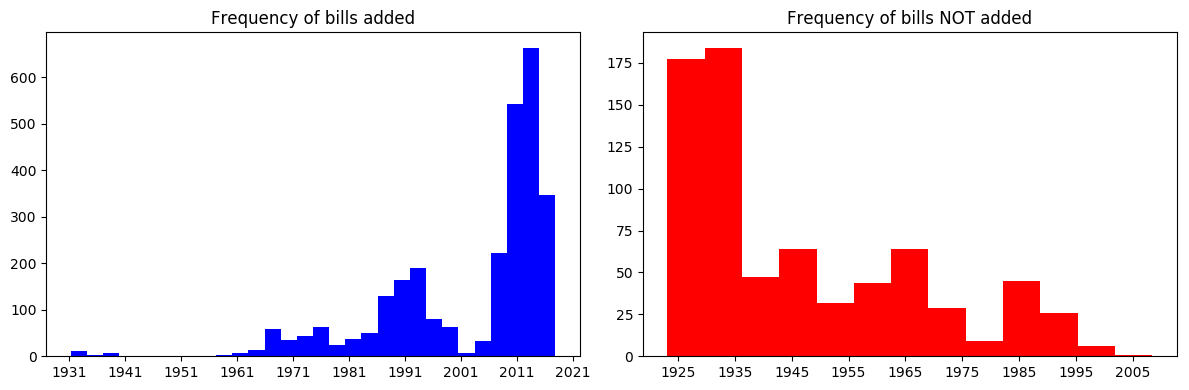

In [67]:
plot_bills_analysed(added, not_added)

In [68]:
# Votings gathered from those bills WITH a Sponsor (all of them, if not we disregard it)
Counter([s[1] == 1 for s in seanad_votings])

Counter({False: 75487})

In [69]:
# Votings gathered from those bills WITH and WITHOUT Co-ponsors
Counter([s[2][0] == 1 for s in seanad_votings]), Counter([s[2][1] == 1 for s in seanad_votings])

(Counter({False: 69877, True: 5610}), Counter({False: 67207, True: 8280}))

In [70]:
# Votings gathered from those bills WITH and WITHOUT members Against
Counter([s[3][0] == 1 for s in seanad_votings]), Counter([s[3][1] == 1 for s in seanad_votings])

(Counter({False: 69795, True: 5692}), Counter({False: 67990, True: 7497}))

In [71]:
def plot_votings_analysed(v):

    plt.figure(figsize=(12, 4), dpi=100)
    
    values = {}
    values.setdefault(True, [])
    values.setdefault(False, [])
    labels = []
    
    c = Counter([s[1] == 1 for s in v]).most_common()
    values[True].append(0)
    values[False].append(c[False][1])
    labels.append('Sponsor')
    
    c = Counter([s[2][0] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Co-sponsor 1')
    c = Counter([s[2][1] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Co-sponsor 2')
    
    c = Counter([s[3][0] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Against 1')
    c = Counter([s[3][1] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Against 2')

    plt.bar(range(1, 6), values[False], width=0.4, color='b', align='center')
    bars = plt.bar(np.arange(1, 6) + 0.4, values[True], width=0.4, color='r', align='center')
    for bar in bars:
        h = bar.get_height()
        if h == 0:
            continue
        plt.text(bar.get_x() + bar.get_width() / 5, h * 1.1, str('{}'.format(h)))
    plt.xticks(range(1, 6), labels)
    
    plt.title('Votings analysed and NOT analysed from the bills extracted')

    plt.show()

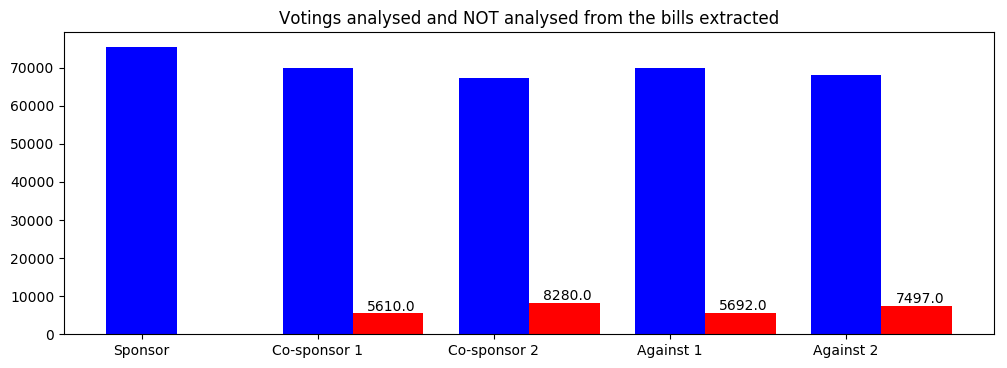

In [72]:
plot_votings_analysed(seanad_votings)

From the bills extracted at the Seanad, most of them contain co-sponsors and members against

In [73]:
def plot_outcome_per_party(outcomes, house):
    
    df = pd.DataFrame(outcomes)
    
    grouped = df[df['house'] == house].groupby(['sponsor', 'outcome']).size()
    
    unstacked = grouped.unstack()
    
    print unstacked
    
    unstacked.plot.bar(
        stacked=False, colormap= 'Set1_r', figsize=(16, 4), grid=False)
    ax = plt.axes()
    # x_axis = ax.axes.get_xaxis()
    # x_axis.set_ticklabels([])
    plt.title('House %s - Votings outcomes per party' % (house))
    plt.ylabel('# Votings')
    plt.xlabel('Parties')
    plt.show()

outcome      Carried  Lost
sponsor                   
Fianna Fáil     12.0   3.0
Fine Gael       48.0   3.0
Green Party      NaN   1.0
Independent     11.0  27.0
Labour           1.0   4.0
Sinn Féin        NaN  24.0


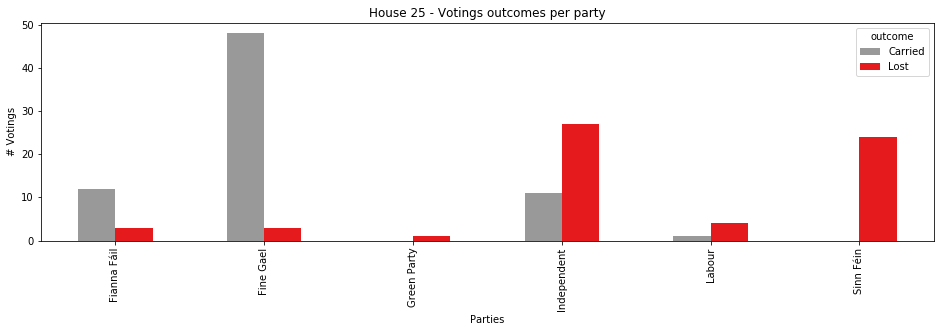

In [74]:
current_house = '25'
plot_outcome_per_party(seanad_outcomes, current_house)

In [75]:
# Dail votings

dail_votings, added, not_added, dail_outcomes = get_vote_data(dail_data, deputy_to_id, deputy_id_to_displayname)

In [76]:
len(dail_votings), len(added), len(not_added), len(dail_outcomes)

(148744, 3574, 1426, 3574)

In [77]:
# dail_votings

In [78]:
# A particular vote
dail_votings[0]

(1, 350, [272, 332], [252, 62])

In [79]:
float(len(added)) / (len(added) + len(not_added))

0.7148

More than 70% of the votings were extracted which resulted in almost 150K individual votes in the Dail

In [80]:
min(added), max(added)

(datetime.datetime(1940, 5, 22, 0, 0), datetime.datetime(2017, 11, 30, 0, 0))

In [81]:
min(not_added), max(not_added)

(datetime.datetime(1940, 5, 22, 0, 0), datetime.datetime(2008, 12, 3, 0, 0))

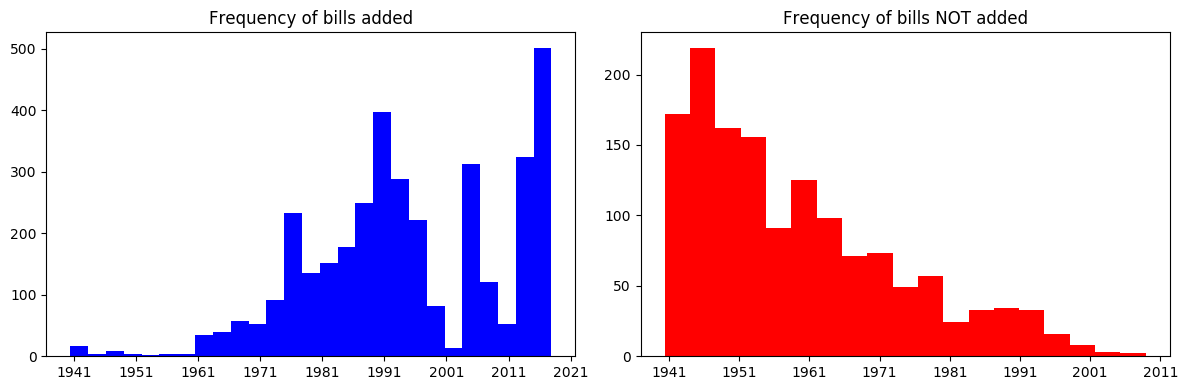

In [82]:
plot_bills_analysed(added, not_added)

In [83]:
Counter([s[1] == 1 for s in dail_votings])

Counter({False: 148744})

In [84]:
Counter([s[2][0] == 1 for s in dail_votings]).most_common()

[(False, 100332), (True, 48412)]

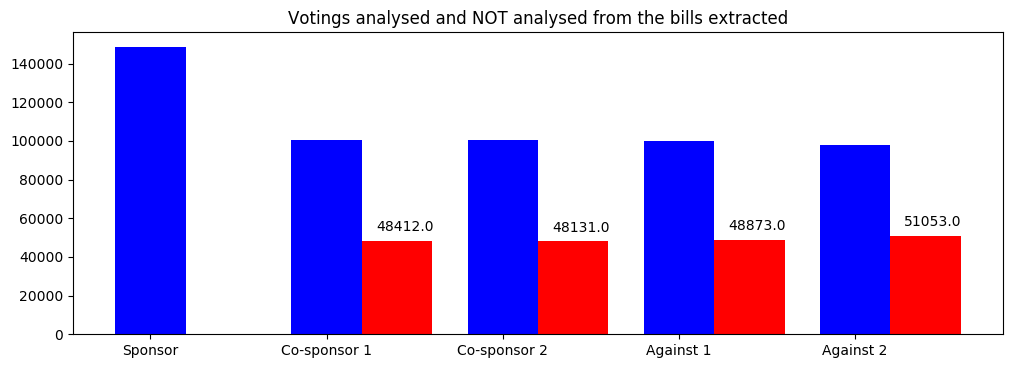

In [85]:
plot_votings_analysed(dail_votings)

In [86]:
# current_house = '32'
# df = pd.DataFrame(dail_outcomes)
# print df.house.unique()
# df[df['house'] == current_house].groupby(['sponsor', 'outcome']).count()

outcome                                         Carried  Lost    _
sponsor                                                           
Anti-Austerity Alliance - People Before Profit      NaN   9.0  1.0
Fianna Fáil                                        17.0  12.0  NaN
Fine Gael                                          96.0  27.0  1.0
Green Party                                         NaN   2.0  NaN
Independent                                         1.0   9.0  NaN
Independents 4 Change                               NaN  23.0  NaN
Labour                                              2.0   5.0  NaN
Sinn Féin                                           2.0  42.0  NaN
Social Democrats                                    NaN   6.0  NaN
Solidarity - People Before Profit                   NaN  28.0  NaN


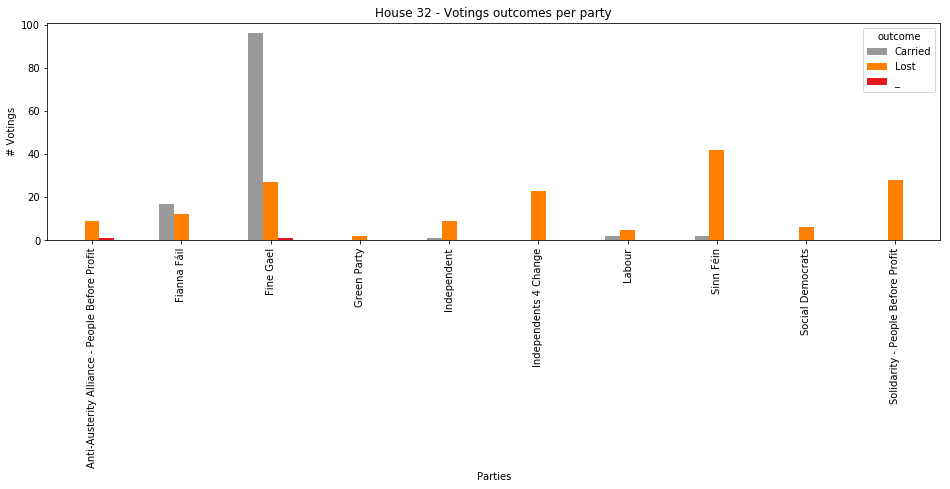

In [87]:
current_house = '32'
plot_outcome_per_party(dail_outcomes, current_house)

Total of individual votes extracted per house:

In [88]:
'Seanad votings {:,}'.format(len(seanad_votings)), 'Dail votings {:,}'.format(len(dail_votings))

('Seanad votings 75,487', 'Dail votings 148,744')

### Senate votings

~75 examples of (vote, senator voting, sponsor, cosponsor, against, coagainst) tuples

In [89]:
y = [d[0] for d in seanad_votings]

In [90]:
# len(y)
Counter(y)

Counter({0: 36729, 1: 38758})

In [91]:
# Padding or cropping
# Not needed as all the votes have the same numer of sponsors (2) and against (2)
limit = 2
def pad_or_crop(lst, l=limit):
    return (lst + [0] * l)[:limit]

In [92]:
x_1 = np.array(map(lambda x: x[1], seanad_votings))
x_2 = np.array(map(lambda x: pad_or_crop(x[2]), seanad_votings))
x_3 = np.array(map(lambda x: pad_or_crop(x[3]), seanad_votings))
x = [x_1, x_2, x_3]

In [93]:
# len(x)

In [94]:
# we add in padding and unknown senators
senator_id_to_displayname[0] = '<PAD>'
senator_id_to_displayname[1] = '<NOT A SENATOR>'

In [95]:
# senator_id_to_displayname

In [96]:
# this gives us how many representations:
len(senator_id_to_displayname)

199

In [97]:
# we again need to write down the metadata
with open('%s/senator_metadata.csv' % (data_path), 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for key, value in sorted(senator_id_to_displayname.items()):
        writer.writerow([value.encode('utf8')])

In [98]:
# finally we build our model
from keras.layers import concatenate
from keras.layers import Dense, Input, Flatten
from keras.layers import MaxPooling1D, Embedding

embedding_layer = Embedding(len(senator_id_to_displayname), 100)

# train a 1D convnet with global maxpooling
voting = voting_input = Input(shape=(1,), dtype='int32')
voting = embedding_layer(voting)
voting = Dense(32, activation='relu')(voting)
voting = Dense(32, activation='relu')(voting)

sponsor = sponsor_input = Input(shape=(limit,), dtype='int32')
sponsor = embedding_layer(sponsor)
sponsor = MaxPooling1D(limit)(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)

cosponsor = cosponsor_input = Input(shape=(limit,), dtype='int32')
cosponsor = embedding_layer(cosponsor)
cosponsor = MaxPooling1D(limit)(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)

combined = concatenate([voting, sponsor, cosponsor])
combined = Dense(32, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)

Using TensorFlow backend.


In [99]:
from keras.models import Model
from keras.callbacks import TensorBoard

model = Model([voting_input, sponsor_input, cosponsor_input], combined)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

embedding_metadata = {
    embedding_layer.name: '../senator_metadata.csv'
}

model.fit([x_1, x_2, x_3], np.array(y).reshape(-1, 1, 1),
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[TensorBoard(log_dir='%s/senator_reps' % (data_path), 
                                 embeddings_freq=1,
                                 embeddings_metadata=embedding_metadata)])

Train on 60389 samples, validate on 15098 samples
Epoch 1/10
60389/60389 [==============================] - 4s 59us/step - loss: 0.2789 - acc: 0.8800 - val_loss: 0.4404 - val_acc: 0.8270
Epoch 2/10
60389/60389 [==============================] - 3s 54us/step - loss: 0.1470 - acc: 0.9460 - val_loss: 0.3496 - val_acc: 0.8801
Epoch 3/10
60389/60389 [==============================] - 4s 61us/step - loss: 0.1278 - acc: 0.9505 - val_loss: 0.3566 - val_acc: 0.8826
Epoch 4/10
60389/60389 [==============================] - 3s 54us/step - loss: 0.1204 - acc: 0.9526 - val_loss: 0.3199 - val_acc: 0.8876
Epoch 5/10
60389/60389 [==============================] - 3s 54us/step - loss: 0.1158 - acc: 0.9540 - val_loss: 0.3062 - val_acc: 0.8912
Epoch 6/10
60389/60389 [==============================] - 4s 65us/step - loss: 0.1125 - acc: 0.9548 - val_loss: 0.3240 - val_acc: 0.9005
Epoch 7/10
60389/60389 [==============================] - 4s 62us/step - loss: 0.1098 - acc: 0.9561 - val_loss: 0.3215 - val_acc

In data/congress/Ireland, launch TensorBoard:
    
> $ tensorboard --logdir=senator_reps/

Go to TensorBoard:

> http://localhost:6006/#projector
        
In TensorBoard, we can look at the representations created in our model using t-SNE or PCA.

### Dail votings

~100K examples of (vote, senator voting, sponsor, cosponsor, against, coagainst) tuples.

In [100]:
y = [d[0] for d in dail_votings]

In [101]:
# len(y)
Counter(y)

Counter({0: 69948, 1: 78796})

In [102]:
x_1 = np.array(map(lambda x: x[1], dail_votings))
x_2 = np.array(map(lambda x: pad_or_crop(x[2]), dail_votings))
x_3 = np.array(map(lambda x: pad_or_crop(x[3]), dail_votings))
x = [x_1, x_2, x_3]

In [103]:
# we add in padding and unknown senators
deputy_id_to_displayname[0] = '<PAD>'
deputy_id_to_displayname[1] = '<NOT A DEPUTY>'

In [104]:
# deputy_id_to_displayname

In [105]:
len(deputy_id_to_displayname)

374

In [106]:
# we again need to write down the metadata
with open('%s/deputy_metadata.csv' % (data_path), 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for key, value in sorted(deputy_id_to_displayname.items()):
        writer.writerow([value.encode('utf8')])

In [107]:
# finally we build our model
from keras.layers import concatenate
from keras.layers import Dense, Input, Flatten
from keras.layers import MaxPooling1D, Embedding

embedding_layer = Embedding(len(deputy_id_to_displayname), 100)

# train a 1D convnet with global maxpooling
voting = voting_input = Input(shape=(1,), dtype='int32')
voting = embedding_layer(voting)
voting = Dense(32, activation='relu')(voting)
voting = Dense(32, activation='relu')(voting)

sponsor = sponsor_input = Input(shape=(limit,), dtype='int32')
sponsor = embedding_layer(sponsor)
sponsor = MaxPooling1D(limit)(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)

cosponsor = cosponsor_input = Input(shape=(limit,), dtype='int32')
cosponsor = embedding_layer(cosponsor)
cosponsor = MaxPooling1D(limit)(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)

combined = concatenate([voting, sponsor, cosponsor])
combined = Dense(32, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)

In [108]:
from keras.models import Model
from keras.callbacks import TensorBoard

model = Model([voting_input, sponsor_input, cosponsor_input], combined)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

embedding_metadata = {
    embedding_layer.name: '../deputy_metadata.csv'
}

model.fit([x_1, x_2, x_3], np.array(y).reshape(-1, 1, 1),
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[TensorBoard(log_dir='%s/deputy_reps' % (data_path), 
                                 embeddings_freq=1,
                                 embeddings_metadata=embedding_metadata)])

Train on 118995 samples, validate on 29749 samples
Epoch 1/10
118995/118995 [==============================] - 7s 57us/step - loss: 0.2787 - acc: 0.8806 - val_loss: 0.4853 - val_acc: 0.8171
Epoch 2/10
118995/118995 [==============================] - 7s 60us/step - loss: 0.2099 - acc: 0.9208 - val_loss: 0.4736 - val_acc: 0.8190
Epoch 3/10
118995/118995 [==============================] - 7s 57us/step - loss: 0.1818 - acc: 0.9292 - val_loss: 0.4795 - val_acc: 0.8207
Epoch 4/10
118995/118995 [==============================] - 7s 60us/step - loss: 0.1689 - acc: 0.9340 - val_loss: 0.4773 - val_acc: 0.8198
Epoch 5/10
118995/118995 [==============================] - 7s 61us/step - loss: 0.1616 - acc: 0.9369 - val_loss: 0.4767 - val_acc: 0.8173
Epoch 6/10
118995/118995 [==============================] - 7s 56us/step - loss: 0.1571 - acc: 0.9386 - val_loss: 0.4773 - val_acc: 0.8188
Epoch 7/10
118995/118995 [==============================] - 7s 61us/step - loss: 0.1541 - acc: 0.9398 - val_loss: 0

In data/congress/Ireland, launch TensorBoard:
    
> $ tensorboard --logdir=deputy_reps/

### Utils

In [109]:
print '\xc3\xa1' == str('á')
print str('á').decode('utf-8').encode('utf-8')
print str('á').decode('utf-8').encode('utf-8') == str('\xc3\xa1')
print str('Tá').decode('utf-8').encode('utf-8') == str('T\xc3\xa1')
print str('Níl').decode('utf-8').encode('utf-8') == str('N\xc3\xadl')

True
á
True
True
True
